In [1]:
import os
import time
from collections import OrderedDict
from typing import Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.transforms.functional import to_tensor
from torchmetrics import BLEUScore

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split

import wandb


# set WANDB_NOTEBOOK_NAME 
os.environ['WANDB_NOTEBOOK_NAME'] = 'mc2.ipynb'


# Challenge
Aufgabe dieser Mini-Challenge ist es ein Image Catptioning Modell zu bauen, dass auf dem Paper [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/pdf/1411.4555.pdf) basiert. Das Modell soll in der Lage sein, eine Beschreibung zu einem Bild zu generieren. Das Modell basiert auf einem Encoder, welche das Bild in ein Imageembedding transformiert und einem Decoder (ein LSTM), welcher die Beschreibung generiert. Input des LSTM ist zuerst das Imageembedding und dann der das Embedding des Starttoken. Der Output des LSTM bildet die Basis für die Generierung des nächsten Wortes. Das Modell wird mit dem Flickr8k Dataset trainiert.

# Config

In der config werden diverse Hyperparameter festgehalten. Wichtig ist vorallem der Parameter seed, welcher beim train-test-split für Reproduzierbarkeit sorgt. So besteht das Testset auch zwischen mehreren Runs aus den gleichen Bildern.

In [112]:
config = dict(
    epochs=150,
    batch_size=128,
    learning_rate=0.001,
    accelerator='gpu' if torch.cuda.is_available() else None,
    image_dir = 'flickr8k/images',
    caption_file = 'flickr8k/captions.txt',
    embedding_dim = 512,
    hidden_dim = 512,
    lstm_layers = 1,
    max_caption_length = 15,
    beam_size = 2,
    seed = 42,
    debug = False,
)

config

{'epochs': 150,
 'batch_size': 128,
 'learning_rate': 0.001,
 'accelerator': 'gpu',
 'image_dir': 'flickr8k/images',
 'caption_file': 'flickr8k/captions.txt',
 'embedding_dim': 512,
 'hidden_dim': 512,
 'lstm_layers': 1,
 'max_caption_length': 15,
 'beam_size': 2,
 'seed': 42,
 'debug': False}

# Vocabulary

Dem Computer kann man nicht einfach ganze Sätze füttern. Sie müssen so transformiert werden, dass sie mit mathematischen Operationen weiter verarbeitet werden können. Dazu werden die Sätze in Tokens aufgeteilt. Dazu gibt es mehrere Ansätze. Ein einfacher Ansatz ist, Spezialzeichen zu entfernen, alles kleinschreiben und für jedes Wort ein Token zu erstellen. Diesen haben ich hier verwendet. Um das Training zu erleichtern, werden vier Spezialtokens definiert:
- `<sos>` Markiert den Start einer Beschreibung. Das wird später der erste Token sein, dessen Embedding nach dem Imageembedding in das LSTM gefüttert wird.
- `<eos>` Markiert das Ende einer Beschreibung. Damit wissen wir später, wann das LSTM uns sagt, dass die Beschreibung fertig ist.
- `<pad>` Da die Beschreibungen unterschiedlich lang sind und wir das Trainieren batched durchführen wollen, müssen wir die Beschreibungen auf eine feste Länge bringen. Dazu werden kurze Beschreibungen mit dem padding token aufgefüllt. So können wir auch einfach beim Loss sagen, welche Tokens ignoriert werden sollen.
- `<unk>` Damit Wörter, die nicht in den Trainingsdaten vorkommen, auch enkodiert werden können gibt es ein Unknown token. Das `<unk>` Token hat des Weiteren den Vorteil, dass nicht für jedes Wort (z.B. Wörter mit Tippfehlern) ein Token erstellt werden muss. Somit kann man das Vokabular klein halten (spart Computingressouren).

Es werden alle Wörter weggelassen, die weniger als 3 mal vorkommen. Das Vokabular ist somit nur noch halb so gross (4097 Tokens).

In [113]:
class Vocab():

    def __init__(self, captions_file, tokenizer):
        self.tokenizer = tokenizer
        self.captions_file = captions_file
        self.build_vocab()

    def build_vocab(self):
        vocab = OrderedDict()

        # Add special tokens
        vocab['<pad>'] = None
        vocab['<sos>'] = None
        vocab['<eos>'] = None
        vocab['<unk>'] = None

        captions = pd.read_csv(config["caption_file"], delimiter='|')['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', ' ', regex=True)
        if config["debug"]:
            captions = captions[:500:5]
        
        token_freq = {}
        for caption in captions:
            for token in self.tokenizer(caption):
                if token not in token_freq:
                    token_freq[token] = 1
                else:
                    token_freq[token] += 1

        for token, freq in token_freq.items():
            if freq >= 3:
                vocab[token] = None


        self.idx2word = list(vocab.keys())
        self.word2idx = {word: idx for idx, word in enumerate(self.idx2word)}

        self.pad_idx = self.word2idx['<pad>']
        self.sos_idx = self.word2idx['<sos>']
        self.eos_idx = self.word2idx['<eos>']

    def __len__(self):
        return len(self.idx2word)

    def token_to_idx(self, token):
        if token not in self.word2idx:
            return self.word2idx['<unk>']
        else:
            return self.word2idx[token]

    def idx_to_token(self, idx):
        return self.idx2word[idx]


special_word_tokenizer = RegexpTokenizer( r'(?:\w+|<\w+>)') # capture special <word> tokens

vocab = Vocab(config["caption_file"], tokenizer=special_word_tokenizer.tokenize)

print(f'Vocab size: {len(vocab)}, Pad index: {vocab.pad_idx}, SOS index: {vocab.sos_idx}, EOS index: {vocab.eos_idx}')

Vocab size: 4097, Pad index: 0, SOS index: 1, EOS index: 2


In [4]:
# debug vocab
test_string = 'a brown dog is running on the grass, like florin!'
print(f'Original string: {test_string}')
tokenized_string = special_word_tokenizer.tokenize(test_string)
print(f'Tokenized string: {tokenized_string}')
tokenized_string_idx = [vocab.token_to_idx(token) for token in tokenized_string]
print(f'Tokenized string indices: {tokenized_string_idx}')
converted_string = [vocab.idx_to_token(idx) for idx in tokenized_string_idx]
print(f'Converted string: {converted_string}')

Original string: a brown dog is running on the grass, like florin!
Tokenized string: ['a', 'brown', 'dog', 'is', 'running', 'on', 'the', 'grass', 'like', 'florin']
Tokenized string indices: [4, 42, 29, 9, 114, 39, 24, 66, 1160, 3]
Converted string: ['a', 'brown', 'dog', 'is', 'running', 'on', 'the', 'grass', 'like', '<unk>']


So sieht ein Satz aus, welcher tokenized wurde und wieder zurück konvertiert wurde.

# Dataset
Das Dataset liesst die Beschreibungen und Bilder ein. Da ich aber im Traindataset nicht die gleichen Bilder wie im Testdataset haben möchte, kann man eine Liste mit image_ids mitgeben, nach denen gefiltert wird. Um das trainieren zu Beschleunigen, lese ich die Bilder schon beim Initialisieren ein und halte sie im Memory. Dort wende ich auch auch gleich eine Transformation an. Als Transformation verwende ich die selbe, wie sie auch auf dem Bildern für die vortrainierten Modelle verwendet wurde. Für die beiden Modelle (resnet50, densenet201) die ich verwende sind die Transformationen wie folgt: 
- Resize auf 232x232 (mit Bilinearer Interpolation für zu kleine Bilder)
- Zentrales Cropping auf 224x224
- Skalieren der Werte auf [0.0, 1.0]
- Dann normalisieren mit mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

Die Option `group_by_image` ermöglicht es, die Datenpunkte nach Bilder zu gruppieren und dann alle Captions auf einmal zurückzugeben. Sonst wird immer eine Caption mit dem dazugehörigen Bild zurückgegeben. Wenn ich auf den Testdaten den BLEU-Score berechne, dann brauche ich aber alle Captions für das Bild. Deshalb habe ich diese Option eingeführt.

In [115]:
class Flickr8kDataset(Dataset):
    def __init__(self, root_dir, captions_file, image_ids, tokenizer, vocab, transform=None, group_by_image=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            captions_file (string): Path to the txt file with captions.
            image_ids (list): List of image ids to use.
            tokenizer (callable): Tokenizer for captions.
            vocab (Vocab): Vocab object.
            transform (callable, optional): Optional transform to be applied
                on a image sample.
            group_by_image (bool): Group captions by image. If True then each image will return all its captions.
        """
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file, delimiter='|')
        if image_ids is not None:
            self.df = self.df[self.df['image_name'].isin(image_ids)]
        if config["debug"]:
            # select only the first 10 images for testing
            self.df = self.df[:100:1]
        self.transform = transform
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.group_by_image = group_by_image

        # clean caption_text
        self.df['caption_text'] = self.df['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', " ", regex=True)
        # append <start> and <end> to caption_text
        self.df['caption_text'] = self.df['caption_text'].apply(lambda x: '<sos> ' + x + ' <eos>') \
                                                         .apply(lambda x: torch.LongTensor(self._caption_to_idx(x)))
        # store memory
        self.captions_image_names = list(zip(self.df['caption_text'], self.df['image_name']))
        
        self.images = {}

        # load all images into memory
        for img_name in tqdm(self.df['image_name'].unique()):
            img_path = os.path.join(self.root_dir, img_name)
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)

            self.images[img_name] = image

    def _caption_to_idx(self, caption):
        return [self.vocab.token_to_idx(word) for word in self.tokenizer(caption)]
    
    def __len__(self):
        if self.group_by_image:
            return len(self.images)
        else:
            return len(self.df)

    def __getitem__(self, idx):
        if self.group_by_image:
            img_name = list(self.images.keys())[idx]
            image = self.images[img_name]
            captions = self.df[self.df['image_name'] == img_name]['caption_text'].tolist()
            return image, captions, img_name
        else:
            caption, img_name = self.captions_image_names[idx]
            image = self.images[img_name]
            return image, caption, img_name

Die Sequenzen wie sie vom Dataset zurückgegeben werden, haben nicht alle die gleiche Länge (weil die Beschreibung der Bilder auch nicht immer gleich lange ist). Damit sie aber in eine zwei-dimensionale Matrix abgespeichert werden können, müssen alle die gleiche Länge haben. Dies kann man erreichen indem man alle zu kurzen Sequenzen mit dem Padding-Token auffüllt, sodass alle Sequenzen gleichlange sind.  

In [100]:
class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        images, captions, image_ids = zip(*batch)
        images = torch.stack(images)
        image_ids = list(image_ids)
        if isinstance(captions[0], list): # for group_by_image=True
            captions = [torch.nn.utils.rnn.pad_sequence(caption, batch_first=True, padding_value=self.pad_idx) for caption in captions]
        else:
            captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return images, captions, image_ids

In [101]:
dataset_group_by_image = Flickr8kDataset(config["image_dir"],
                          config["caption_file"],
                          None,
                          special_word_tokenizer.tokenize,
                          vocab,
                          models.ResNet50_Weights.IMAGENET1K_V1.transforms(),
                          group_by_image=True)

100%|██████████| 20/20 [00:00<00:00, 47.52it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


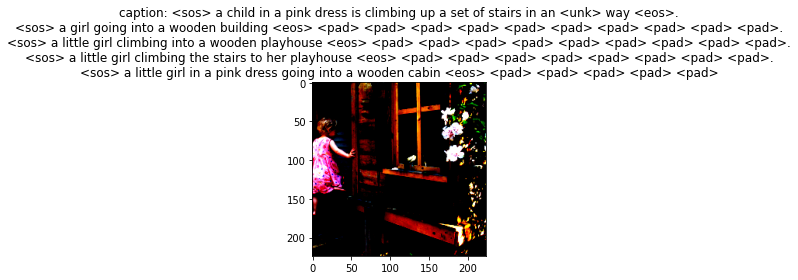

In [103]:
data_loader_group_by_image = DataLoader(dataset_group_by_image,
                         batch_size=config["batch_size"],
                         shuffle=False,
                         pin_memory=True,
                         collate_fn=Collate(vocab.pad_idx))
for i, (images, captions, image_ids) in enumerate(data_loader_group_by_image):
    token_captions = captions[0]
    reconstructed_caption = [[vocab.idx_to_token(idx) for idx in token_caption] for token_caption in token_captions]
    plt.imshow(images[0].permute(1, 2, 0))
    strs = '.\n'.join([' '.join(cap) for cap in reconstructed_caption])
    plt.title(f"caption: {strs}")
    plt.tight_layout()
    plt.show()
    break

Hier ist ein Bild mit den 5 captions (tokenized) zu sehen. Da das Bild schon transformiert wurde, wird es von matplotlib nicht richtig dargestellt. Aber man erkennt trotzdem noch, dass das Bild zu den Beschreibungen passt.

In [47]:
test_dataset = Flickr8kDataset(config["image_dir"],
                          config["caption_file"],
                          None,
                          special_word_tokenizer.tokenize,
                          vocab,
                          models.ResNet50_Weights.IMAGENET1K_V1.transforms(),
                          group_by_image=False)
test_data_loader = DataLoader(test_dataset,
                         batch_size=config["batch_size"],
                         shuffle=False,
                         pin_memory=True,
                         collate_fn=Collate(vocab.pad_idx))

100%|██████████| 8091/8091 [01:25<00:00, 94.75it/s]


In [61]:
# analyze the captions lengths
lengths = []
total_data_loader_len = len(test_data_loader)
for i, (images, captions, image_ids) in tqdm(enumerate(test_loader), total=total_data_loader_len):
    for caption in captions:
        lengths.append(np.array(caption.size(1) - (caption == vocab.pad_idx).sum(dim=1)))

 20%|██        | 64/317 [00:25<01:41,  2.48it/s]


In [59]:
# convert lengths to numpy array
np.concatenate(lengths).shape

(40455,)

Der Datensatz Flickr8k beinhaltet 8091 Bilder und 40455 Beschreibungen dazu.

Captions lengths shape: (40455,)


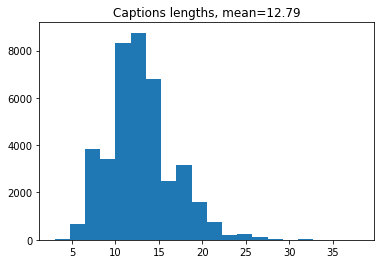

In [60]:
lengths_arr = np.concatenate(lengths)

print("Captions lengths shape:", lengths_arr.shape)

plt.hist(lengths_arr, bins=20)
plt.title("Captions lengths, mean={:.2f}".format(lengths_arr.mean()))
plt.show()


Hier ist die Verteilung der Länge der Beschreibungen zu sehen. Die meisten Beschreibungen sind zwischen 10 und 15 Wörter lang. Die wenigsten Beschreibungen sind länger als 30 Wörter. Das hat mich dazu bewegt, die max_length auf 30 zu setzen.

# Model v1

Das Modell besteht aus einem Encoder und Decoder. Des Encoder setzt sich aus dem Modell Resnet50 (welche auf sogenannten Residualblocks besteht: (Die Daten teilen sich auf, ein Pfad führt durch zwei Convolutionlayers wonach das Resultat mit dem anderen Pfad (der keine Berechnungen durchläuft) zusammen addiert wird)), einem Linearlayer und Batchnorm-Layer besteht. Die Layer des Resnets werden gefreezed und nicht neu trainiert. Das nennt sich Transfer-Learning. Diese Featureextraction ist dazu da, das Bild in einem kleineren Raum zu embedden um es dann in das LSTM zu füttern. 

Der Decoder besteht aus drei Teilen: dem Embedding-Layer, dem LSTM und dem inversen Embedding-Layer.
- Der Embedding-Layer kann die Tokens in einen Featurevektor transformieren. Dieser Vektor hat die gleiche Grösse wie das Embedding des Bildes. Damit kann auch dieses Embedding in das LSTM gefüttert werden.
- Der inverse Embedding-Layer kann aus dem Output des LSTMs wieder Tokens berechnen (respektive die Wahrscheinlichkeit für jedes Token). Dazu wird der LogSoftmax verwendet. Dadurch kann beim optimieren der negative log likelihood als Loss verwendet werden. 
- Das LSTM ist das eigentliche Herzstück dieses Modells. Es nimmt die image und word embeddings und kann daraus das nächste Wort generieren. Dabei behält es einen hidden und cell state (das long und short term Memory) um sich über lang Zeit die Informationen aus dem Bild zu merken. Da LSTM ist eine Variante eines RNNs. Interessant ist, dass hier das Trainieren und Vorhersagen nicht genau abläuft. Während man beim Trainieren alle Embeddings auf einmal mitgibt (Teacher-Forcing) und so gleichzeitig das nächste Wort vorhersagen kann, muss man beim Vorhersagen die Embeddings nacheinander einfügen. Denn das nächste Embedding ergibt sich aus dem Output des vorherigen Embeddings.

Um die Wörter vorherzusagen gibt es zwei Varianten: erstens Beam-Search und zweitens Greedy-Search (was ein Spezialfall von Beam-Search ist (mit k=1)). Bei Greedy-Search wird pro Bild/Token jeweils genau ein Token vorhergesagt und als nächsten LSTM-Input verwendet. Bei Beam-Search werden beim ersten Token die k besten Vorhersagen behalten. Beim nächsten Token werden dann für jedes der k Tokens die k besten Vorhersagen behalten. Damit die Anzahl der Pfade aber nicht exponentiell wächst, werden jeweils die k*k Vorhersagen wieder auf die k besten Vorhersagen reduziert. Wenn eine Sequenz das Endtoken vorhersagt, wird dieser Ast als beendet markiert. Für die restlichen Pfade wird Beamsearch so weitergeführt, bis alle k-Pfade das Endtoken erreicht haben oder die maximale Länge erreicht wurde. Die Sequenz mit der höchsten Wahrscheinlichkeit wird dann als Caption verwendet. Diese Wahrscheinlichkeit ist die Summe der Logarithmen der Wahrscheinlichkeiten der einzelnen Tokens. Da der Logarithmus nicht positiv ist, hat Beamsearch die Tendenz kürzere Beschreibungen zu wählen.

Die Performance auf dem Testset wird mit dem BLEU-Score berechnet. Diese Metrik misst die Ähnlichkeit der generierten Beschreibung zu den 5 Referenzsätzen. Der BLEU-Score schaut ob die generierte Beschreibung die gleichen Wörter enthält wie die Referenzsätze. Dabei wird aber nicht nur die Übereinstimmung der Wörter betrachtet, sondern auch die Reihenfolge der Wörter.


In [104]:

class ImageCaptioning(pl.LightningModule):

    def __init__(self, embedding_dim: int, lstm_layers: int, hidden_dim: int, vocabulary_size: int, padding_idx: int, learning_rate: float):
        super(ImageCaptioning, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Sequential(*list(models.resnet50(weights=models.ResNet50_Weights.DEFAULT).children())[:-1]),
            nn.Flatten(),
            nn.Linear(models.resnet50().fc.in_features, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        for param in self.encoder[0].parameters():
            param.requires_grad_(False)

        # Decoder
        self.decoder = nn.ModuleDict({
            'embedding_layer': nn.Embedding(vocabulary_size, embedding_dim),
            'lstm': nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=lstm_layers, dropout = 0.5),
            'inv_embedding': nn.Sequential(nn.Linear(hidden_dim, vocabulary_size), nn.LogSoftmax(dim=2))
        })
        
        self.learning_rate = learning_rate

        self.bleu_score = BLEUScore(smooth=True)

        self.save_hyperparameters()


    def forward(self, images: torch.Tensor, captions: torch.Tensor) -> torch.Tensor:
        # Encoder forward
        # images: (batch_size, channels, pixels, pixels)
        image_embedding = self.encoder(images) # (batch_size, embedding_dim)

        # Decoder forward
        word_embeddings = self.decoder['embedding_layer'](captions).permute(1, 0, 2) # (seq_len, batch_size, embedding_dim)
        
        embeddings = torch.cat((image_embedding.unsqueeze(0), word_embeddings), dim=0)

        outputs, _ = self.decoder['lstm'](embeddings) # (seq_len, batch_size, embedding_dim)
        outputs = self.decoder['inv_embedding'](outputs) # (seq_len, batch_size, vocab_size)
        return outputs


    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.learning_rate, weight_decay=0.0001)

    
    def training_step(self, batch, batch_idx):
        self.train()
        images, captions, image_ids = batch
        outputs = self(images, captions[:,:-1])
        outputs = outputs[1:].reshape(-1, outputs.size(2)) # remove the first word from the output
        captions = captions.permute(1, 0)[1:].reshape(-1) # remove the first word from the target
        loss = F.nll_loss(outputs, captions, ignore_index=int(vocab.pad_idx))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        self.eval()
        images, captions, image_ids = batch
        outputs = self(images, captions[:,:-1])
        outputs = outputs[1:].reshape(-1, outputs.size(2)) # remove the first word from the output
        captions = captions.permute(1, 0)[1:].reshape(-1) # remove the first word from the target
        loss = F.nll_loss(outputs, captions, ignore_index=int(vocab.pad_idx))
        self.log('val_loss', loss)
        return loss
    

    def test_step(self, batch, batch_idx, beam_size: int = 2):
        """
        Compute the BLEU score for the generated captions
        """
        self.eval()
        images, target_caption_groups, image_ids = batch # captions contain all the 5 possible captions for each image
        outputs_gredy = self.sample_greedy(images, max_length=config["max_caption_length"])
        outputs_beam = self.sample_beam(images, max_length=config["max_caption_length"], beam_size=config["beam_size"])

        # filter out the <eos>, <sos> and <pad> tokens
        generated_sentences_greedy = []
        for caption in outputs_gredy:
            tokens = []
            for idx in caption:
                if idx != vocab.eos_idx:
                    tokens.append(vocab.idx_to_token(idx))
                else:
                    break 
            generated_sentences_greedy.append(" ".join(tokens))
        
        generated_sentences_beam = []
        for caption in outputs_beam:
            tokens = []
            for idx in caption:
                if idx != vocab.eos_idx:
                    tokens.append(vocab.idx_to_token(idx))
                else:
                    break 
            generated_sentences_beam.append(" ".join(tokens))

        target_sentence_groups = []
        for target_caption_group in target_caption_groups:
            target_sentences = []
            for caption in target_caption_group:
                tokens = []
                for idx in caption:
                    if idx == vocab.sos_idx:
                        continue
                    if idx != vocab.eos_idx:
                        tokens.append(vocab.idx_to_token(idx))
                    else:
                        break 
                target_sentences.append(" ".join(tokens))
            target_sentence_groups.append(target_sentences)

        self.log_dict({
            'bleu_score_greedy': self.bleu_score(generated_sentences_greedy, target_sentence_groups),
            'bleu_score_beam': self.bleu_score(generated_sentences_beam, target_sentence_groups)
        })

    def sample_greedy(self, images: torch.Tensor, max_length: int = 15):
        self.eval()
        image_embeddings = self.encoder(images).unsqueeze(0) # (1, batch_size, embedding_dim)
        input_tokens = torch.tensor([[vocab.sos_idx]], device=images.device).repeat(1, images.size(0)) # (1, batch_size)

        output, hidden = self.decoder['lstm'](image_embeddings)

        generated_captions = []
        for _ in range(max_length):
            # Embed the input
            input_embeddings = self.decoder['embedding_layer'](input_tokens)
            
            # LSTM forward
            outputs, hidden = self.decoder['lstm'](input_embeddings, hidden)
            outputs = self.decoder['inv_embedding'](outputs)
            
            # Get the maximum probable words (greedy decoding)
            predicted_word_idx = outputs.argmax(dim=2)
            generated_captions.append(predicted_word_idx)

            input_tokens = predicted_word_idx # (1, batch_size)

        return torch.cat(generated_captions, dim=0).permute(1, 0).tolist() # (batch_size, max_length)

    def sample_beam(self, images: torch.Tensor, max_length: int = 20, beam_size: int = 2):
        self.eval()
        batch_size = images.size(0)
        image_embeddings = self.encoder(images).unsqueeze(0) # (1, batch_size, embedding_dim)
        
        # loop over the batch
        generated_captions = []
        for i in range(batch_size):
            image_embedding = image_embeddings[:, i, :] # (1,  embedding_dim)
            input_token = torch.tensor([[vocab.sos_idx]], device=images.device) # (1,1)
            
            outputs, (hidden, cell) = self.decoder['lstm'](image_embedding) # (1, embedding_dim), ((1, embedding_dim), (1, embedding_dim))
            
            final_beams = []
            beam = [(input_token, 0, (hidden.unsqueeze(0), cell.unsqueeze(0)))] # (token, score, (h_n, c_n))
            for _ in range(max_length):
                # print("Iteration:", _)
                input_embeddings = self.decoder['embedding_layer'](torch.cat([tokens[-1] for tokens, _, _ in beam], dim=0)).unsqueeze(0) # (1, beam_size[old], embedding_dim)

                # LSTM forward
                hidden = torch.cat([h_n for _, _, (h_n, c_n) in beam], dim=1)#.unsqueeze(0) # (1, beam_size[old], embedding_dim)
                cell = torch.cat([c_n for _, _, (h_n, c_n) in beam], dim=1)#.unsqueeze(0) # (1, beam_size[old], embedding_dim)

                outputs, (hidden, cell) = self.decoder['lstm'](input_embeddings, (hidden, cell)) # (1, beam_size[old], embedding_dim), ()
                outputs = self.decoder['inv_embedding'](outputs) # (1, beam_size[old], vocab_size)

                # Get the maximum probable beam_size words (beam search)
                predicted_word_idx = outputs.topk(beam_size, dim=2) # (values, indices): ((1, beam_size[old], beam_size[new]), (1, beam_size[old], beam_size[new]))
                # select the top beam_size words for each beam
                new_beam = []
                for ii, (token, score, (h_n, c_n)) in enumerate(beam):
                    for j in range(beam_size):
                        new_token = torch.cat([token, predicted_word_idx[1][:, ii, j].unsqueeze(1)], dim=0)
                        new_score = score + predicted_word_idx[0][:, ii, j] # log softmax can be added to get the probability
                        new_hidden = hidden[:, ii, :].unsqueeze(0)
                        new_cell = cell[:, ii, :].unsqueeze(0)
                        new_beam.append((new_token, new_score, (new_hidden, new_cell)))
                beam = []

                # filter out finished beams
                for b in new_beam:
                    if b[0][-1] == vocab.eos_idx:
                        final_beams.append(b)
                    else:
                        beam.append(b)
                
                # sort the beam by score
                beam = sorted(beam, key=lambda x: x[1], reverse=True)[:max(0,beam_size-len(final_beams))]
                # check if all the beams have the <eos> token
                if len(beam) == 0:
                    break

            # append any beams left to the final beams
            final_beams.extend(beam)

            # select the best beam
            final_beam = sorted(final_beams, key=lambda x: x[1], reverse=True)[0]

            generated_captions.append(final_beam[0].squeeze(1).tolist()[1:]) # remove the <sos> token

        return generated_captions # (batch_size, max_length)

image_captioning = ImageCaptioning(512, 1, 1024, len(vocab), vocab.pad_idx, 0.001).to(torch.device('cuda')) # just to get feedback faster, not used in pl.Trainer 

image_captioning.train()

# create random tensor of images and captions 
images = torch.randn(32, 3, 500, 500).to(torch.device('cuda')) # just to get feedback faster, not used in pl.Trainer 
# sequence of 40 words
captions = torch.randint(0, len(vocab), (32, 40)).to(torch.device('cuda')) # just to get feedback faster, not used in pl.Trainer 
print("captions:", captions.size())

outputs = image_captioning(images, captions[:,:-1])


print("outputs:", outputs.size())

# compute loss
#loss = nn.NLLLoss()(outputs.permute(1, 2, 0), captions.permute(1, 0))
loss = nn.NLLLoss(ignore_index=int(vocab.pad_idx))(outputs.reshape(-1, outputs.size(2)), captions.reshape(-1))

print("loss:", loss)

# check if on cuda
print(next(image_captioning.parameters()).is_cuda)
print(next(image_captioning.encoder.parameters()).is_cuda)
print(next(image_captioning.decoder['embedding_layer'].parameters()).is_cuda)
print(next(image_captioning.decoder['lstm'].parameters()).is_cuda)
print(next(image_captioning.decoder['inv_embedding'].parameters()).is_cuda)
print(outputs.is_cuda)

# convert outputs to captions_idx
captions = torch.argmax(outputs, dim=2)
print("captions:", captions.size())

# convert captions_idx to captions
captions = [[vocab.idx_to_token(idx.item()) for idx in caption] for caption in captions]
print("captions:", captions[0])

# 5 images
image = torch.randn(8, 3, 500, 500).to(torch.device('cuda')) 
caption = image_captioning.sample_greedy(image)
print("Generated caption:", caption)
beam_caption = image_captioning.sample_beam(image)
print("Generated caption:", beam_caption)
caption_sentence = [vocab.idx_to_token(idx) for idx in caption[0]]
target_sentences = [" ".join(caption) for caption in captions]
bleu_score = image_captioning.bleu_score(caption_sentence, target_sentences)
print("BLEU score:", bleu_score)

c:\Users\flori\miniconda3\envs\del\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


captions: torch.Size([32, 40])
outputs: torch.Size([40, 32, 4097])
loss: tensor(8.3196, device='cuda:0', grad_fn=<NllLossBackward0>)
True
True
True
True
True
True
captions: torch.Size([40, 32])
captions: ['travel', 'flapping', 'jockey', 'overhead', 'mesh', 'rocket', 'knit', 'mime', 'gaze', 'motorcyclists', 'rival', 'gazing', 'wrestler', 'fence', 'tea', 'shaved', 'sink', 'cat', 'shadow', 'move', 'stare', 'mop', 'distorted', 'acting', 'missing', 'vehicles', 'that', 'spaghetti', 'sparks', 'bush', 'oxen', 'teens']
Generated caption: [[2129, 610, 2802, 3688, 1636, 2177, 3742, 524, 1962, 709, 3797, 1813, 1526, 2010, 245], [2129, 610, 2802, 3688, 1636, 2177, 3742, 524, 1962, 709, 3797, 1813, 1526, 2010, 245], [2129, 610, 2802, 3688, 1636, 2177, 3742, 524, 1962, 709, 3797, 1813, 1526, 2010, 245], [2129, 610, 2802, 3688, 1636, 2177, 3742, 524, 1962, 709, 3797, 1813, 1526, 2010, 245], [2129, 610, 2802, 3688, 1636, 2177, 3742, 524, 1962, 709, 3797, 1813, 1526, 2010, 245], [2129, 610, 2802, 3688, 

# Data Module

Das Data-Module ist zuständig um einen Train-Test-Split durchzuführen. Dieser wird auf Basis der Bilder gemacht. Würde man ihn auf Basis der Beschreibungen machen, würden die Trainingsdaten in die Testdaten leaken (das Gleiche Bild wäre in beiden Datensätzen und im worst-case würde der BLEU-Score die Ähnlichkeit zwischen den Referenzsätzen berechnen).

Zum Trainieren werden 80% der Daten verwendet. Weitere 10% werden zum validieren nach jeder Epoche verwendet. Die restlichen 10% werden zum Testen verwendet. Die Daten des Testdataloader werden nach Bilder gruppiert zurückgegeben, damit kann der BLEU-Score erst berechnet werden.

In [117]:
class Flickr8kDataModule(pl.LightningDataModule):
    def __init__(self, config, transform=None):
        super().__init__()
        self.config = config
        self.transform = transform
        self.special_word_tokenizer = RegexpTokenizer( r'(?:\w+|<\w+>)') # capture <word> tokens
        self.vocab = Vocab(self.config["caption_file"], tokenizer=self.special_word_tokenizer.tokenize)
        self.config['vocab_size'] = len(self.vocab)
        self.collate_fn = Collate(self.vocab.pad_idx)


    def setup(self, stage=None):
        # check if train_dataset variable exists
        if hasattr(self, 'train_dataset'):
            return
        # read the dataframe and make split on images
        df = pd.read_csv(self.config["caption_file"], delimiter='|')
        image_ids = df['image_name'].unique()

        train_image_ids, test_image_ids = train_test_split(image_ids, test_size=0.2, random_state=self.config["seed"]) # 80% train
        val_image_ids, test_image_ids = train_test_split(test_image_ids, test_size=0.5, random_state=self.config["seed"]) # 10% val, 10% test

        # create datasets
        self.train_dataset = Flickr8kDataset(self.config["image_dir"],
                                        self.config["caption_file"],
                                        train_image_ids,
                                        self.special_word_tokenizer.tokenize,
                                        self.vocab,
                                        self.transform)
        self.val_dataset = Flickr8kDataset(self.config["image_dir"],
                                        self.config["caption_file"],
                                        val_image_ids,
                                        self.special_word_tokenizer.tokenize,
                                        self.vocab,
                                        self.transform)
        self.test_dataset = Flickr8kDataset(self.config["image_dir"],
                                        self.config["caption_file"],
                                        test_image_ids,
                                        self.special_word_tokenizer.tokenize,
                                        self.vocab,
                                        self.transform,
                                        group_by_image=True)

    def dataloader(self, dataset, shuffle=False, collate=True):
        return DataLoader(dataset,
                          batch_size=self.config["batch_size"],
                          shuffle=shuffle,
                          pin_memory=True,
                          collate_fn=Collate(self.vocab.pad_idx))


    def train_dataloader(self): return self.dataloader(self.train_dataset, shuffle=True)
    def val_dataloader  (self): return self.dataloader(self.val_dataset)
    def test_dataloader (self): return self.dataloader(self.test_dataset, collate=False)

flickr8k_data_module = Flickr8kDataModule(config, transform=models.ResNet50_Weights.IMAGENET1K_V1.transforms())

# Training Modell v1

Das Training erfolgt über den PyTorch-Trainer. Dort gebe ich zwei Callbacks mit:
- ModelCheckpoint: sorgt dafür, dass ab und zu die weights des Modells gespeichert werden. Dabei wird das Modell nur gespeichert, wenn es einen besser val_loss erzeilt.
- EarlyStopping: sorgt dafür, dass das Training abgebrochen wird, wenn der val_loss nicht mehr besser wird. Dabei wird das Training abgebrochen, wenn der val_loss für 5 Epochen nicht mehr besser wird.

Ich habe eine Hyperparametertuning für die hidden_dim und embedding_dim durchgeführt. 

In [80]:
for dim_size in [512, 1024, 2048, 4096, 8192]:
    config["hidden_dim"] = dim_size
    config["embedding_dim"] = dim_size
    wandb_logger = WandbLogger(name=f"v1-dim-{dim_size}", project="del-mc2", entity="florin-barbisch", config=config, log_model="all")

    model = ImageCaptioning(
        config["embedding_dim"],
        config["lstm_layers"],
        config["hidden_dim"],
        len(flickr8k_data_module.vocab),
        flickr8k_data_module.vocab.pad_idx,
        config["learning_rate"]
    )

    wandb_logger.watch(model, log="all")

    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss')
    early_stopping_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    trainer = pl.Trainer(
        accelerator = config["accelerator"],
        max_epochs = config["epochs"],
        callbacks = [checkpoint_callback, early_stopping_callback],
        logger = wandb_logger,
        log_every_n_steps = 10
    )

    trainer.fit(model, flickr8k_data_module)
    trainer.test(model, flickr8k_data_module.test_dataloader())
    wandb.finish()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 24.6 M
1 | decoder    | ModuleDict | 6.3 M 
2 | bleu_score | BLEUScore  | 0     
------------------------------------------
7.4 M     Trainable params
23.5 M    Non-trainable params
30.9 M    Total params
123.435   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.09829098731279373
    bleu_score_greedy       0.10580360144376755
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


bleu_score_beam,▁
bleu_score_greedy,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████
train_loss,█▇▆▅▄▄▄▃▄▃▃▃▂▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_loss,█▁
bleu_score_beam,0.09829
bleu_score_greedy,0.1058
epoch,2
train_loss,2.92908
trainer/global_step,632


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 25.6 M
1 | decoder    | ModuleDict | 16.8 M
2 | bleu_score | BLEUScore  | 0     
------------------------------------------
18.9 M    Trainable params
23.5 M    Non-trainable params
42.4 M    Total params
169.599   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████████
train_loss,█▆▆▅▄▄▄▃▃▃▃▃▃▃▂▃▃▂▂▃▂▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▁
epoch,1
train_loss,2.70667
trainer/global_step,479
val_loss,3.15244


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 27.7 M
1 | decoder    | ModuleDict | 50.4 M
2 | bleu_score | BLEUScore  | 0     
------------------------------------------
54.6 M    Trainable params
23.5 M    Non-trainable params
78.1 M    Total params
312.259   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam       0.035882383584976196
    bleu_score_greedy       0.05355777218937874
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


bleu_score_beam,▁
bleu_score_greedy,▁
epoch,▁▁▁
train_loss,█▁
trainer/global_step,▁▆█
bleu_score_beam,0.03588
bleu_score_greedy,0.05356
epoch,0
train_loss,4.21672
trainer/global_step,24


Problem at: c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\loggers\wandb.py 405 experiment


KeyboardInterrupt: 

# Evaluation Modell v1

In [124]:
# load image ids and images from the test_loader
image_ids = []
images = []
target_captions = []
#flickr8k_data_module.setup()
test_loader = flickr8k_data_module.test_dataloader()
for i, (image, captions, image_ids) in tqdm(enumerate(test_loader), total=len(test_loader)):
    image_ids.extend(image_ids)
    images.extend(image)
    target_captions.extend(captions)
    if i == 0:
        break # don't need more than 128 images

  0%|          | 0/7 [00:00<?, ?it/s]


# Evaluate BLEU Score
Beim generieren des BLEU-Scores hat es zwei Parameter, von denen ich vermute, dass sie die Performance beeinflussen:
- max_caption_length
- beam_size: Dies gilt nur für Beamsearch. Ich vermute, dass der Einfluss von max_caption_length relativ unabhängig ist (da Beamsearch einen Bias für kürzere Sätze hat).


In [25]:
artifact_dir = wandb.Api().artifact(f"florin-barbisch/del-mc2/model-2lbny888:best_k").download()
model = ImageCaptioning.load_from_checkpoint(os.path.join(artifact_dir, "model.ckpt"))
trainer = pl.Trainer()

wandb: Downloading large artifact model-2lbny888:best_k, 306.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


## Evaluate on different caption lengths

In [26]:
results = []
for max_caption_length in [10, 15, 20, 25, 30, 35, 40]:
    for beam_size in [2, 3, 4, 5]:
        config["max_caption_length"] = max_caption_length
        config["beam_size"] = beam_size
        metrics = trainer.test(model, flickr8k_data_module.test_dataloader())
        results.append({
            "max_caption_length": max_caption_length,
            "beam_size": beam_size,
            "bleu_score_greedy": metrics[0]['bleu_score_greedy'],
            "bleu_score_beam": metrics[0]['bleu_score_beam']
        })

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.08901931345462799
    bleu_score_greedy       0.09271679073572159
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.08644389361143112
    bleu_score_greedy       0.09271679073572159
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.08442177623510361
    bleu_score_greedy       0.09271679073572159
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.08305612951517105
    bleu_score_greedy       0.09271679073572159
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.11096175760030746
    bleu_score_greedy       0.12486544251441956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.10270010679960251
    bleu_score_greedy       0.12486544251441956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.09669148921966553
    bleu_score_greedy       0.12486544251441956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.09214728325605392
    bleu_score_greedy       0.12486544251441956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.11227952688932419
    bleu_score_greedy       0.10975836217403412
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.10395141690969467
    bleu_score_greedy       0.10975836217403412
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0969390794634819
    bleu_score_greedy       0.10975836217403412
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0925348550081253
    bleu_score_greedy       0.10975836217403412
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.11229399591684341
    bleu_score_greedy       0.08688481897115707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.10397815704345703
    bleu_score_greedy       0.08688481897115707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0969390794634819
    bleu_score_greedy       0.08688481897115707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0925348550081253
    bleu_score_greedy       0.08688481897115707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.11229399591684341
    bleu_score_greedy       0.07171960920095444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.10397815704345703
    bleu_score_greedy       0.07171960920095444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0969390794634819
    bleu_score_greedy       0.07171960920095444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0925348550081253
    bleu_score_greedy       0.07171960920095444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.11229399591684341
    bleu_score_greedy       0.06106547266244888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.10397815704345703
    bleu_score_greedy       0.06106547266244888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0969390794634819
    bleu_score_greedy       0.06106547266244888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0925348550081253
    bleu_score_greedy       0.06106547266244888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.11229399591684341
    bleu_score_greedy      0.053156327456235886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.10397815704345703
    bleu_score_greedy      0.053156327456235886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0969390794634819
    bleu_score_greedy      0.053156327456235886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.0925348550081253
    bleu_score_greedy      0.053156327456235886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [66]:
df_results = pd.DataFrame(results).reset_index()

Text(0.5, 1.0, 'BLEU score for greedy search for different max_caption_length')

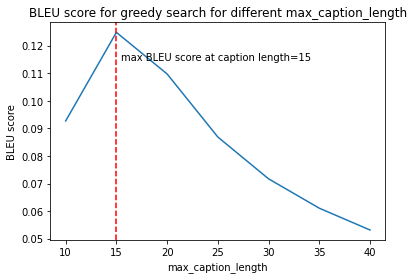

In [72]:
df_greedy = df_results[df_results['beam_size'] == 2]
plt.plot(df_greedy['max_caption_length'], df_greedy['bleu_score_greedy'])
_ = plt.axvline(df_greedy['max_caption_length'][df_greedy['bleu_score_greedy'].idxmax()], color='r', linestyle='--')
plt.text(df_greedy['max_caption_length'][df_greedy['bleu_score_greedy'].idxmax()] + 0.5, df_greedy['bleu_score_greedy'].max() - 0.01, f"max BLEU score at caption length={df_greedy['max_caption_length'][df_greedy['bleu_score_greedy'].idxmax()]}")
plt.xlabel("max_caption_length")
plt.ylabel("BLEU score")
plt.title("BLEU score for greedy search for different max_caption_length")

Wie dieser Grafik zu entnehmen ist, ist der optimale BLEU score bei 15. Das ist nahe bei der durchschnittlichen Länge der Beschreibungen.

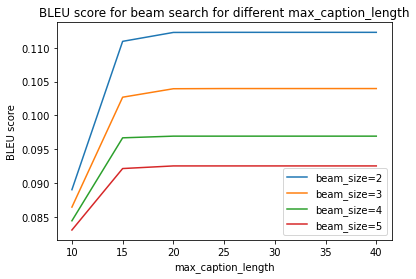

In [75]:
for k in [2, 3, 4, 5]:
    df_beam = df_results[df_results['beam_size'] == k]
    plt.plot(df_beam['max_caption_length'], df_beam['bleu_score_beam'], label=f"beam_size={k}")
plt.legend()
plt.xlabel("max_caption_length")
plt.ylabel("BLEU score")
plt.title("BLEU score for beam search for different max_caption_length")
plt.show()

Dieser Grafik ist zu entnehmen, dass der BLEU-Score nach 20 Wörter nicht mehr zunimmt. Und von 15 auf 20 Wörter ist der Zuwachs nur minimal. Der BLEU-Score wird hier nicht wieder schlechter wie in der Grafik darüber, weil Beamsearch einen Bias für kürzere Sätze hat.

Zu meiner Vermutung: max-caption-length hat einen Einfluss auf den BLEU-Score, aber nur bis zu einer max_caption_length von 20.

Da Greedy-Search bessere Resultate erzielt hat, nehme ich die max_caption_length von 15.

# Model v2

Mein zweites Modell unterscheidet sich nicht stark zum ersten. Ich möchte hier nur herausfinden, ob eine andere CNN-Architektur aus einem ähnlichen Zeitraum gleiche Ergebnisse liefert. Auch habe ich hier das grösste CNN der Reihe verwendet.

Die Densenet Blöcke haben ähnlich wie ResNet auch Verbindungen die gewisse Layers umgehen. So werden innerhalb eines Densenet-Blocks alle Layers miteinander verbunden. Durch diese Skip-Connections (auch wie sie im ResNet verwendet wurden), können CNN-Modelle tiefer werden.

In [77]:
class ImageCaptioningV2(ImageCaptioning):
    def __init__(self, embedding_dim: int, lstm_layers: int, hidden_dim: int, vocabulary_size: int, padding_idx: int, learning_rate: float):
        super(ImageCaptioningV2, self).__init__(embedding_dim, lstm_layers, hidden_dim, vocabulary_size, padding_idx, learning_rate)

        # Encoder
        self.encoder = nn.Sequential(
            models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1),
            nn.BatchNorm1d(embedding_dim)
        )
        for param in self.encoder[0].parameters():
            param.requires_grad_(False)
        
        self.encoder[0].classifier = nn.Linear(self.encoder[0].classifier.in_features, embedding_dim)


Gleich wie beim ersten Modell habe ich ein Hyperparametertuning für die hidden_dim und embedding_dim durchgeführt.

# Training Modell v2

In [24]:
for dim_size in[512, 1024, 2048, 4096, 8192]:
    config["hidden_dim"] = dim_size
    config["embedding_dim"] = dim_size
    wandb_logger = WandbLogger(name=f"v2-dim-{dim_size}", project="del-mc2", entity="florin-barbisch", config=config, log_model="all")

    model = ImageCaptioningV2(
        config["embedding_dim"],
        config["lstm_layers"],
        config["hidden_dim"],
        len(flickr8k_data_module.vocab),
        flickr8k_data_module.vocab.pad_idx,
        config["learning_rate"]
    )

    wandb_logger.watch(model, log="all")

    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss')
    early_stopping_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    trainer = pl.Trainer(
        accelerator = config["accelerator"],
        max_epochs = config["epochs"],
        callbacks = [checkpoint_callback, early_stopping_callback],
        logger = wandb_logger,
        log_every_n_steps = 10
    )

    trainer.fit(model, flickr8k_data_module)
    trainer.test(model, flickr8k_data_module.test_dataloader())
    wandb.finish()

c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\loggers\wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
c:\Users\flori\miniconda3\envs\del\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential 

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\utilities\data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\utilities\data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 42. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     bleu_score_beam        0.07551676779985428
    bleu_score_greedy      0.028957342728972435
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


bleu_score_beam,▁
bleu_score_greedy,▁
epoch,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁
trainer/global_step,▁▂▃▄▄▅▆▇██
bleu_score_beam,0.07552
bleu_score_greedy,0.02896
epoch,0
train_loss,3.47473
trainer/global_step,91


# Evaluation Modell v2

In [ ]:
# load model from "Run data is saved locally in .\wandb\run-20230608_075712-xf91x694"
#model = ImageCaptioning.load_from_checkpoint("wandb/run-20230608_075712-xf91x694/files/epoch=0-step=0.ckpt")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'group', 'of', 'men', 'in', 'red', 'shirts', 'and', 'black', 'pants', 'are', 'dancing', 'in', 'front', 'of', 'a', 'crowd', '<eos>']]


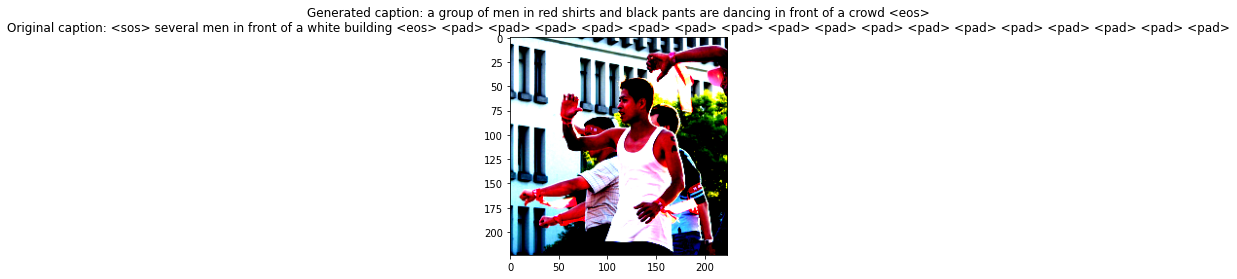

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'woman', 'with', 'a', 'red', 'shirt', 'and', 'a', 'woman', 'with', 'a', 'pink', 'shirt', '<eos>']]


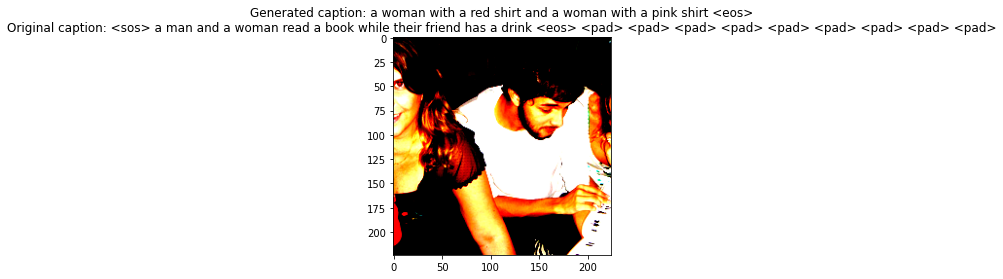

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'woman', 'in', 'a', 'black', 'jacket', 'and', 'sunglasses', 'is', 'smiling', '<eos>']]


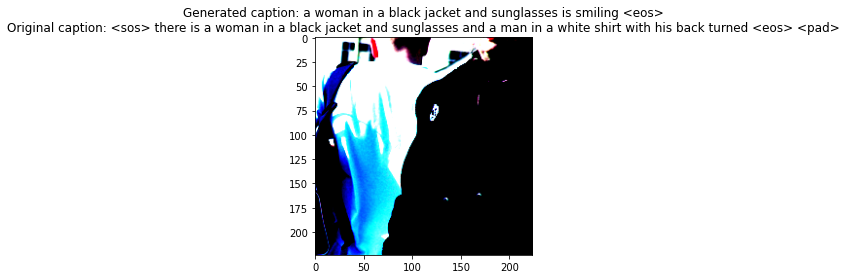

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'brown', 'dog', 'runs', 'through', 'the', 'grass', '<eos>']]


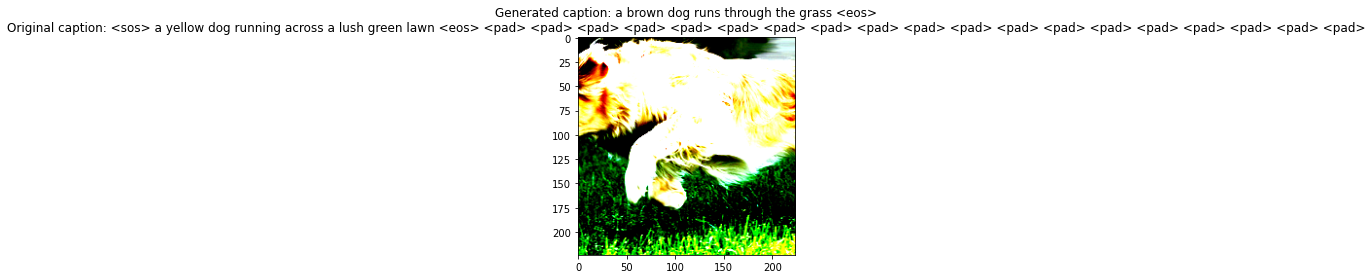

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'dog', 'is', 'running', 'through', 'a', 'field', '<eos>']]


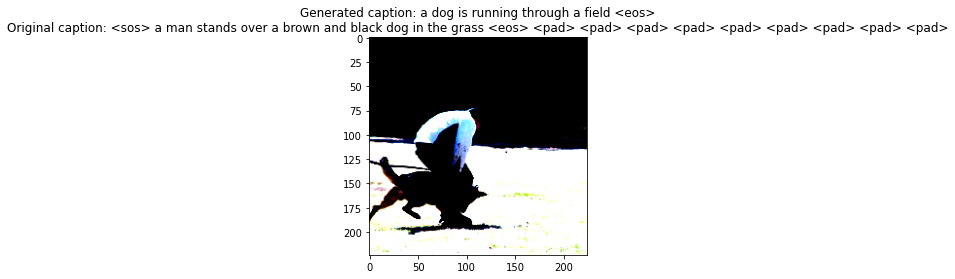

In [20]:
# sample on first image and show the result
model = model.to(torch.device('cuda'))

i = 0
for image, caption, _ in iter(flickr8k_data_module.train_dataloader()):
    if i == 5:
        break
    i += 1
    image = image.to(torch.device('cuda'))
    image = image[0].unsqueeze(0)
    # send image to cuda
    #caption = caption[0].unsqueeze(0)

    generated_caption = model.sample_greedy(image)
    print("Generated caption:", generated_caption)

    plt.imshow(image[0].permute(1, 2, 0).cpu())
    plt.title(f"Generated caption: {' '.join(generated_caption[0])}\nOriginal caption: {' '.join([flickr8k_data_module.vocab.idx_to_token(idx.item()) for idx in caption[0]])}")
    plt.show()